In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [20]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Simple PINN for the integro–differential equation
#   dy/dx(x) + ∫_0^x y(t) dt = 2π cos(2πx) + sin^2(πx)/π
# with initial condition y(0) = 0

class PINN(nn.Module):
    def __init__(self, layers):
        """
        layers: list of layer sizes, e.g. [1, 20, 20, 20, 1]
                index 0  -> input dimension
                last idx -> output dimension
        We build an MLP:
            x -> Linear -> Tanh -> Linear -> Tanh -> ... -> Linear(out)
        """
        super().__init__()

        # nn.Sequential will hold all layers in order
        self.net = nn.Sequential()

        # Build all hidden layers except the final output layer.
        # Example: layers = [1, 20, 20, 20, 1]
        #   len(layers) - 2 = 3  → we build 3 hidden Linear+Tanh blocks
        for i in range(len(layers) - 2):
            # Linear layer i: layers[i]  → layers[i+1]
            self.net.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i+1]))
            # Nonlinear activation after that layer
            self.net.add_module(f"tanh_{i}", nn.Tanh())

        # Final output layer: from second-to-last size to last size
        # (no activation; we want y(x) to be unconstrained real)
        self.net.add_module("output", nn.Linear(layers[-2], layers[-1]))

    def forward(self, x):
        """
        Forward pass of the network.
        Input:
          x: tensor of shape (N, 1) containing the x-locations.
        Output:
          y_hat: tensor of shape (N, 1) approximating y(x).
        """
        return self.net(x)


def compute_loss(model, x_interior, quad_weights):
    """
    Compute the total loss (PDE residual + initial condition).

    x_interior : collocation points in [0,1], shape (N,1)
    quad_weights : trapezoidal quadrature weights for each point, shape (N,1)
                   used to approximate ∫_0^x y(t) dt via cumulative sum.
    """

    # We need gradients dy/dx, so tell PyTorch to track gradients w.r.t x_interior
    x_interior.requires_grad = True

    # Network prediction y(x) at all interior points
    y = model(x_interior)        # shape (N,1)

    # ---- dy/dx term ---------------------------------------------------------
    # autograd.grad computes ∂y/∂x_interior (vector–Jacobian product).
    #   outputs = y
    #   inputs  = x_interior
    #   grad_outputs = ones_like(y) → elementwise derivative dy/dx_i
    # create_graph=True → keep graph for higher-order derivatives if needed.
    dy_dx = torch.autograd.grad(
        y, x_interior,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]                          # shape (N,1)

    # ---- Integral term ∫_0^x y(t) dt ---------------------------------------
    # We approximate the integral using trapezoidal quadrature on the fixed grid
    # 0 = x_0 < x_1 < ... < x_{N-1} = 1 with step size dx.
    #
    # quadrature approximation:
    #   ∫_0^{x_j} y(t) dt ≈ Σ_{i=0}^j w_i * y(x_i)
    # where w_i are the trapezoidal weights (dx/2 at edges, dx inside).
    #
    # y * quad_weights → elementwise product w_i * y_i, shape (N,1)
    # torch.cumsum(..., dim=0)   → prefix sum over i = 0..j,
    #                              giving approximation of ∫_0^{x_j}.
    integral = torch.cumsum(y * quad_weights, dim=0)  # shape (N,1)

    # ---- Right-hand side of the IDE ----------------------------------------
    # RHS(x) = 2π cos(2πx) + sin^2(πx) / π
    rhs = 2 * np.pi * torch.cos(2 * np.pi * x_interior) \
          + (torch.sin(np.pi * x_interior) ** 2) / np.pi

    # ---- Residual of the IDE -----------------------------------------------
    # For each x_i, residual r_i = dy/dx(x_i) + ∫_0^{x_i} y(t)dt - RHS(x_i)
    residual = dy_dx + integral - rhs

    # Mean-squared PDE residual over all interior points
    loss_interior = torch.mean(residual ** 2)

    # ---- Initial condition loss: y(0) = 0 ----------------------------------
    # We evaluate the network at x = 0 explicitly.
    y0 = model(torch.tensor([[0.0]], device=device))  # shape (1,1)
    # Penalize deviation from 0
    loss_ic = torch.mean((y0 - 0.0) ** 2)

    # Total loss = PDE residual loss + IC loss
    return loss_interior + loss_ic


# ============================================================
# Training domain and quadrature weights for trapezoidal rule
# ============================================================

N = 100  # number of grid points in [0,1]

# Uniform grid in [0,1]; shape (N,1)
x_train_np = np.linspace(0, 1, N).reshape(-1, 1)
x_train = torch.tensor(x_train_np, dtype=torch.float32, device=device)

# Grid spacing dx = x_1 - x_0 (tensor scalar)
dx = x_train[1] - x_train[0]
# print(dx)

# Start with interior weights all equal to dx
quad_weights = dx * torch.ones_like(x_train)
# print(quad_weights)

# Trapezoidal rule edge correction:
#   w_0 = w_{N-1} = dx/2, others = dx
quad_weights[0] = quad_weights[-1] = dx / 2

# ============================================================
# Model and optimizer
# ============================================================

# layers = [input_dim=1, hidden1=20, hidden2=20, hidden3=20, output_dim=1]
model = PINN([1, 20, 20, 20, 1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ============================================================
# Training loop
# ============================================================

epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()                           # clear previous gradients
    loss = compute_loss(model, x_train, quad_weights)  # forward + loss
    loss.backward()                                 # backprop: d(loss)/dθ
    optimizer.step()                                # gradient descent update

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 18.973536
Epoch 1000, Loss: 0.000343
Epoch 2000, Loss: 0.000159
Epoch 3000, Loss: 0.000094
Epoch 4000, Loss: 0.000507
Epoch 5000, Loss: 0.000061
Epoch 6000, Loss: 0.000048
Epoch 7000, Loss: 0.000041
Epoch 8000, Loss: 0.000035
Epoch 9000, Loss: 0.000041


In [2]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 4.1 MB/s eta 0:00:00a 0:00:01


In [15]:
# import os
# os.environ["DDE_BACKEND"] = "pytorch"   # or "paddle", "tensorflow", "tensorflow.compat.v1", "jax"

import deepxde as dde
# from deepxde.backend import tf  # TF backend wrapper
dde.backend.set_default_backend("pytorch")
print("Backend:", dde.backend.backend_name)

Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Backend: tensorflow.compat.v1


In [24]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf  # TensorFlow backend utilities


# ============================================================
# 1. Integro-differential equation residual for DeepXDE
#    Equation form (schematically):
#      dy/dx + ∫_0^x y(t) dt = RHS(x)
#
#  -> DeepXDE passes:
#       x       : all training points (interior + boundary + quad points)
#       y       : network output at all those points
#       int_mat : integration matrix constructed from quadrature rule
#                  (encodes weights and kernel for ∫ y(t) dt )
#
#  Our job in `ide`:
#    - Use `int_mat` and `y` to build an integral term
#    - Compute dy/dx via automatic differentiation
#    - Make sure the shapes of "integral term" and "dy/dx - RHS"
#      are consistent so they can be added.
# ============================================================
def ide(x, y, int_mat):
    """Residual of the IDE: dy/dx + ∫_0^x y(t) dt - RHS(x) = 0."""

    # --------------------------------------------------------
    # DeepXDE IDE data object will call this function automatically
    # with:
    #   x : a Tensor of shape (N_total, 1)
    #   y : a Tensor of shape (N_total, 1)
    #   int_mat : a NumPy array or Tensor with shape
    #             (N_eq, N_total)
    #
    # Here:
    #   - N_total includes interior points, boundary points,
    #     and quadrature points.
    #   - N_eq is the number of IDE equations enforced (usually
    #     equal to the number of "IDE interior" points).
    #
    # We must carefully align shapes so that:
    #   tf.matmul(int_mat, y)  -> shape (N_eq, 1)
    #   dy/dx and RHS          -> also shape (N_eq, 1)
    # --------------------------------------------------------

    # Ensure int_mat is a TensorFlow float32 tensor
    # (DeepXDE passes it as NumPy initially).
    int_mat_tf = tf.convert_to_tensor(int_mat, dtype=tf.float32)

    # Integral term: matrix-vector product
    # int_mat_tf has shape (N_eq, N_total)
    # y has shape (N_total, 1)
    # ==> lhs_int has shape (N_eq, 1)
    lhs_int = tf.matmul(int_mat_tf, y)

    # Compute dy/dx over ALL points in x
    ''' 
    Jacobian cal. examples
    1)
    def pde(x, y):
    # x: shape (N, 2)   -> [x, t]
    # y: shape (N, 1)   -> [u(x,t)]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)  # ∂u/∂t
    u_x = dde.grad.jacobian(y, x, i=0, j=0)  # ∂u/∂x
    
    2) 
    def pde(x, y):
    # x: (N, 2) -> [x, y]
    # y: (N, 1) -> u(x,y)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)  # ∂u/∂x
    u_y = dde.grad.jacobian(y, x, i=0, j=1)  # ∂u/∂y    
    '''
    # jacobian(y, x) returns d y / d x component-wise
    dy_dx_all = dde.grad.jacobian(y, x, i=0, j=0)  # shape (N_total, 1)


    '''
    Hessain examples - 2nd derivatives
    1) 
    def pde(x, y):
    # 1D heat/Poisson: u_xx
    u_xx = dde.grad.hessian(y, x, i=0, j=0)  # ∂²u / ∂x²

    2) 
    def pde(x, y):
    # x: [x, y]
    u_xx = dde.grad.hessian(y, x, i=0, j=0)  # ∂²u/∂x²
    u_yy = dde.grad.hessian(y, x, i=0, j=1)  # ∂²u/∂y²
    return u_xx + u_yy + f(x)  # = 0 형태의 PDE residual    
    '''

    
    
    # Compute RHS at ALL x
    rhs_all = (
        2.0 * np.pi * tf.cos(2.0 * np.pi * x)
        + (tf.sin(np.pi * x) ** 2) / np.pi
    )  # shape (N_total, 1)

    # --------------------------------------------------------
    # Now we must match the shape of dy/dx and RHS with the
    # integral term.
    #
    # DeepXDE's IDE data structure arranges the samples in x,y as:
    #   [ domain points,
    #     boundary points,
    #     quadrature points ]
    #
    # and builds int_mat so that each row corresponds to ONE IDE
    # equation (usually associated with a subset of those points).
    #
    # For simplicity, and because we do not have direct access to
    # internal indices here, the most robust approach is to take
    # only the FIRST "N_eq" entries of dy_dx and RHS, where
    # N_eq = int_mat_tf.shape[0].
    # This matches the rows of int_mat.
    # --------------------------------------------------------
    N_eq = tf.shape(int_mat_tf)[0]  # dynamic number of equations

    # Slice dy/dx and RHS to match the first N_eq rows.
    # Now both have shape (N_eq, 1).
    dy_dx = dy_dx_all[:N_eq, :]
    rhs = rhs_all[:N_eq, :]

    # Residual: dy/dx + integral - RHS = 0
    # All terms now have compatible shapes (N_eq, 1).
    residual = dy_dx + lhs_int - rhs

    return residual


# ============================================================
# 2. Reference / analytical solution for initial condition
# ============================================================
def func(x):
    """Exact solution y(x) = sin(2πx) used for initial condition."""
    return np.sin(2 * np.pi * x)


# ============================================================
# 3. Geometry and initial condition
#    TimeDomain(0, 1) means a 1D interval [0, 1].
# ============================================================
geom = dde.geometry.TimeDomain(0, 1)

# IC: y(0) = func(0) = 0
# The lambda selects points on the "initial boundary" (x = 0).
ic = dde.icbc.IC(geom, func, lambda _, on_initial: on_initial)


# ============================================================
# 4. Data object for IDE
#    - geom        : domain [0,1]
#    - ide         : residual function defined above
#    - ic          : initial condition
#    - num_domain  : number of interior points where the IDE is enforced
#    - num_boundary: number of boundary points (here, for x=0)
#    - quad_deg    : quadrature degree used internally to build
#                    the integration matrix int_mat
# ============================================================
quad_deg = 16

data = dde.data.IDE(
    geom,
    ide,          # our IDE residual function
    ic,           # initial condition
    num_domain=16,
    num_boundary=2,
    quad_deg=quad_deg,
)


# ============================================================
# 5. Neural network: simple fully-connected network (FNN)
#    layer_size = [1, 20, 20, 20, 1] means:
#      input dim = 1
#      three hidden layers with 20 neurons each
#      output dim = 1  (y(x))
# ============================================================
layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)


# ============================================================
# 6. Build and compile the PINN-style model in DeepXDE
#    - data : defines geometry, IDE, IC, quadrature strategy
#    - net  : neural network mapping x → y(x)
#    - optimizer : "adam"
#    - lr        : learning rate
# ============================================================
model_pinn = dde.Model(data, net)
model_pinn.compile("adam", lr=0.001)


# ============================================================
# 7. Train the model
# ============================================================
model_pinn.train(iterations=10000)


# ============================================================
# 8. Evaluate and compare against the reference solution
# ============================================================
X = geom.uniform_points(100, True)   # 100 test points in [0,1]
y_true = func(X)                     # exact solution
y_pred = model_pinn.predict(X)       # PINN prediction

print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

# Save data to file for visualization / postprocessing
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))


Compiling model...
Building feed-forward neural network...
'build' took 0.052203 s

'compile' took 0.259620 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.12e+01, 0.00e+00]    [2.12e+01, 0.00e+00]    []  
1000      [6.98e-04, 2.17e-08]    [6.98e-04, 0.00e+00]    []  
2000      [3.16e-04, 5.22e-10]    [3.16e-04, 0.00e+00]    []  
3000      [1.12e-04, 4.38e-12]    [1.12e-04, 0.00e+00]    []  
4000      [3.57e-05, 5.06e-12]    [3.57e-05, 0.00e+00]    []  
5000      [4.15e-05, 4.34e-07]    [4.15e-05, 0.00e+00]    []  
6000      [1.96e-05, 1.10e-09]    [1.96e-05, 0.00e+00]    []  
7000      [4.60e-05, 6.59e-07]    [4.60e-05, 0.00e+00]    []  
8000      [1.51e-05, 7.82e-11]    [1.51e-05, 0.00e+00]    []  
9000      [8.46e-04, 1.83e-05]    [8.46e-04, 0.00e+00]    []  
10000     [1.14e-05, 2.73e-09]    [1.14e-05, 0.00e+00]    []  

Best model at step 10000:
  train loss: 1.14e-05
  test loss: 1.14e-05
  test metric: []

'train' took 8.3

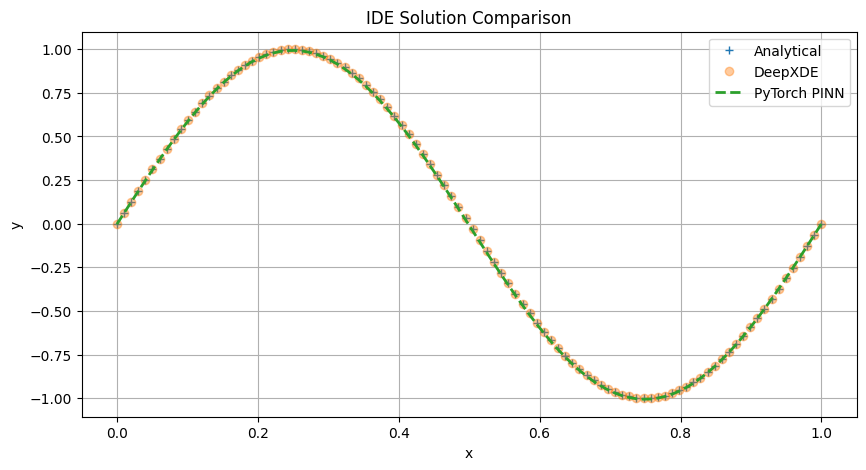

In [25]:
X = x_train_np
X_torch = torch.tensor(X, dtype=torch.float32, device=device)
y_pinn = model(X_torch).detach().cpu().numpy()
y_true = np.sin(2 * np.pi * X)

# Load DeepXDE results
y_deepxde = np.loadtxt("test.dat")[:, 2:3]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(X, y_true, "+", label="Analytical", linewidth=2)
plt.plot(X, y_deepxde, "o", label="DeepXDE", alpha=0.4)
plt.plot(X, y_pinn, "--", label="PyTorch PINN", linewidth=2)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("IDE Solution Comparison")
plt.grid(True)
plt.show()